# Introvert-Extrovert Classification

## Library imports

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mode

import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.utils import resample

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [161]:
df = pd.read_csv("data/train.csv")
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


## Data analysis

In [162]:
X = df.drop(["Personality", "id"], axis=1)
y = df["Personality"]

### Basic information

In [163]:
X.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [164]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1013.2+ KB


We can collect some valuable info from this:

1. All columns have a good quantity of Nans in them (this makes it hard for us to make predictions)
2. ```Stage_fear``` and ```Drained_after_socializing``` are binary columns, having a *yes* or *no* type of data type
3. Most columns have a relatively similar scale, in this case you could or couldn't scale features. In this case we will.
4. Every non-binary feature has a discrete type of data

Also, since we are using a logistic regression model, there is no need to check for distribution of data, since log regressions don't assume data is normally distributed.

### Binary features

In [165]:
from sklearn.base import BaseEstimator, TransformerMixin

class BinaryTransformation(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X["Stage_fear"] = X["Stage_fear"].replace({"No":0, "Yes":1})
        X["Drained_after_socializing"] = X["Drained_after_socializing"].replace({"No": 0, "Yes": 1})
        
        return X

### Nans handling

To handle missing values we will do the following:
1. Since all data is descrete, we will temporarily impute Nans with the features most_frequent value.
2. Using the elbow method divide our data into n clusters.
3. We will extract the cluster's most frequent value and substitute every nan for that value in that specific cluster.

In [166]:
class KMeansImputer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42, init="k-means++"):
        self.random_state = random_state
        self.init = init

    def fit(self, X, y=None):
        self.columns_ = X.columns
        
        X_temp_imputed = SimpleImputer(strategy="most_frequent").fit_transform(X) #Temporarily replace Nans
        inertia = []

        # Elbow method to determine number of clusters
        for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, random_state=33, init="k-means++")
            kmeans.fit(X_temp_imputed)
            inertia.append(kmeans.inertia_)
            
        plt.plot(range(1, 11), inertia, marker='o')
        plt.title('Elbow Method for Optimal k')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()
        
        # User chosen k-value
        self.n_clusters = int(input("Select the k-value you want to train the kmeans model on"))
        
        self.kmeans_fitted = KMeans(n_clusters=self.n_clusters,
                                    random_state=self.random_state,
                                    init=self.init)
        
        df_temp = pd.DataFrame(X, columns=self.columns_,).copy()
        df_temp["Cluster"] = self.kmeans_fitted.fit_predict(X_temp_imputed)
        
        self.cluster_modes_ = {}

        for col in df_temp.columns[:-1]:  # Skip 'Cluster' feature
            self.cluster_modes_[col] = {}
            
            for cluster_id in range(self.n_clusters):
                values = df_temp.loc[
                    (df_temp["Cluster"] == cluster_id) & (~df_temp[col].isna()),
                    col
                ]
                
                if not values.empty:
                    self.cluster_modes_[col][cluster_id] = mode(values)

        return self

    def transform(self, X):
        X_copy = X.copy()
        X_temp = SimpleImputer(strategy="most_frequent").fit_transform(X)
        clusters = self.kmeans_fitted.predict(X_temp)

        df_imputed = pd.DataFrame(X_copy, columns=self.columns_)
        df_imputed["Cluster"] = clusters

        for col in df_imputed.columns[:-1]:  # exclude 'Cluster'
            
            for cluster_id in range(self.n_clusters):
                mask = (df_imputed["Cluster"] == cluster_id) & (df_imputed[col].isna())
                fill_value = self.cluster_modes_[col][cluster_id]
                
                if fill_value is not None:
                    df_imputed.loc[mask, col] = fill_value

        return df_imputed.drop(columns=["Cluster"])


Here we created our own transformer, so that we can later use it in a pipeline

### Class balancing

<Axes: >

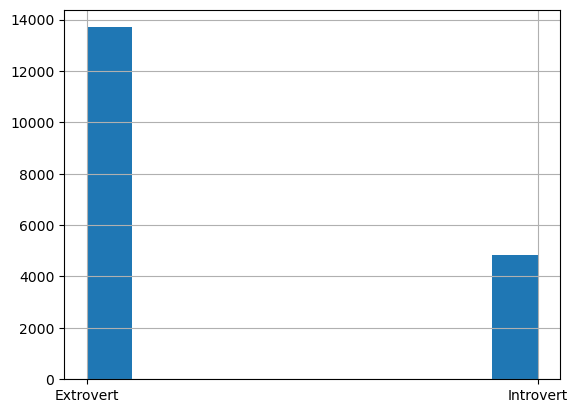

In [167]:
y.hist()

```Extrovert``` class is highly greater that the ```Introvert``` class, so that our model doesn't falsely give us wrong results we might need to balance the classes.

In this case, since the ```Extrovert``` class has a great sample size, our best bet might be to to undersampling (bringing down the number of samples in our majority class)

In [168]:
df_major = df[df["Personality"] == "Extrovert"] # Majority class
df_minor = df[df["Personality"] == "Introvert"] # Minority class

df_under_sample = resample(df_major,
                          replace=False,
                          random_state=21,
                          n_samples=len(df_minor)) # Here we resample the majority class

df_balanced = pd.concat([df_under_sample, df_minor])

In [169]:
X_balanced = df_balanced.drop(["Personality", "id"], axis=1)
y_balanced = df_balanced["Personality"]

<Axes: >

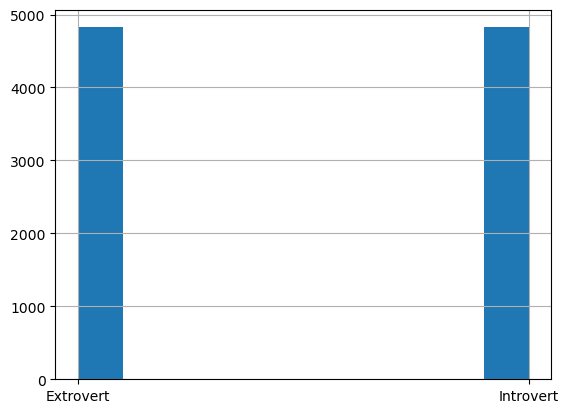

In [170]:
y_balanced.hist()

classes are now balanced

### Data cleaning

In [171]:
data_cleaning = Pipeline([
    ("binary_transformation", BinaryTransformation()),
    ("kmeans_imputing", KMeansImputer()),
    ("scaler", StandardScaler())
])

I created a pipeline for the 3 data cleaning steps

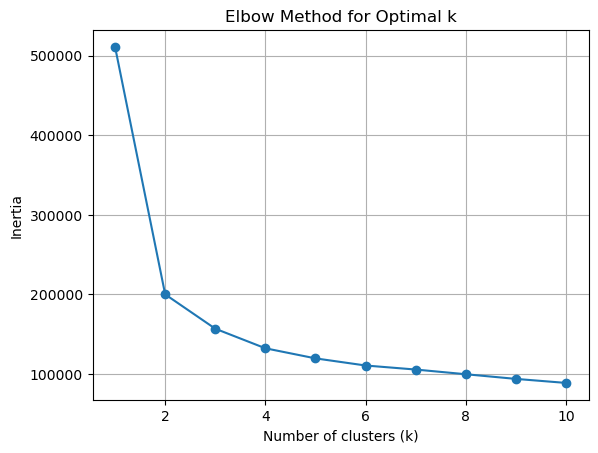

In [172]:
X_cleaned = data_cleaning.fit_transform(X_balanced)

### Correlation analysis

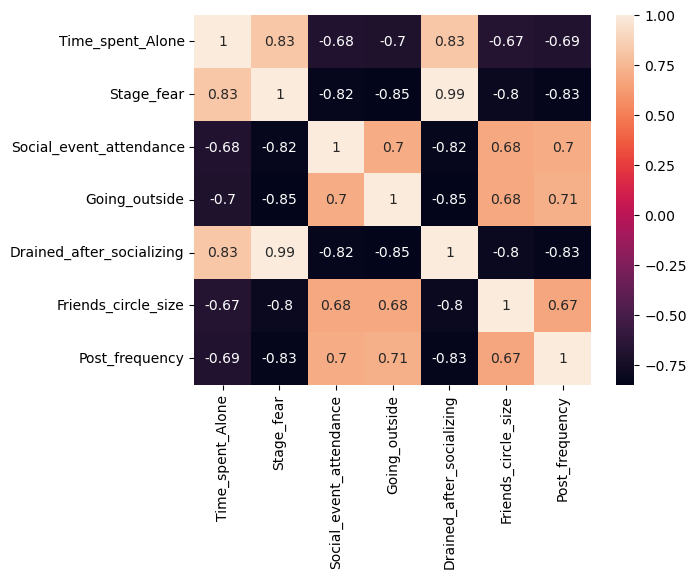

In [173]:
mx_df = pd.DataFrame(X_cleaned, columns=X.columns)
corr_mx = mx_df.corr()
sns.heatmap(corr_mx, annot=True)
plt.show()

This correlation matrix tells us that both binary columns are almost the same variable, having a correlation index of 0.99

For this reason, we will drop them.

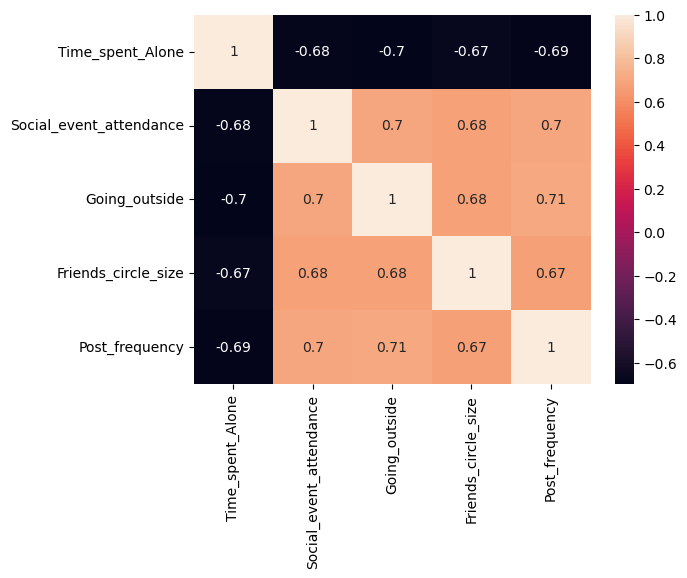

In [174]:
mx_df_dropped = pd.DataFrame(X_cleaned, columns=X.columns).drop(["Stage_fear", "Drained_after_socializing"], axis=1)
corr_mx = mx_df_dropped.corr()
sns.heatmap(corr_mx, annot=True)
plt.show()

After analyzing the correlation of the rest of the features, we can see that most of them have a sort of high correlation. Becuase this can cause problems further on, our best approach will be to do a feature reduction procedure using PCA.

### PCA and GridSearch

To find the best hyperparameters for ```PCA``` and our ```Logistic Regression model``` the best way is to use a grid search. We are checking for 3 main hyperparameters ```n_components```, ```solver```, and ```C``` After a bit of iterating I found out that the best ```C``` oscilated in the lower values.

In [175]:
pipeline_pca_mdoel = Pipeline([
    ("pca", PCA()),
    ("log_reg", LogisticRegression())
])

param_grid = {
    "pca__n_components": [1, 2, 3, 4, 5],
    "log_reg__solver": ["lbfgs", "newton-cholesky", "newton-cg"],
    "log_reg__C" : np.logspace(0.1, 5, 20),
}

grid_search = GridSearchCV(pipeline_pca_mdoel, param_grid, cv=5, scoring="f1_macro")
grid_search.fit(mx_df_dropped, y_balanced)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'log_reg__C': array([1.25892541e+00, 2.27978944e+00, 4.12847324e+00, 7.47625680e+00,
       1.35387618e+01, 2.45173589e+01, 4.43985126e+01, 8.04013161e+01,
       1.45598833e+02, 2.63665090e+02, 4.77471406e+02, 8.64653503e+02,
       1.56580200e+03, 2.83551258e+03, 5.13483291e+03, 9.29867465e+03,
       1.68389803e+04, 3.04937283e+04, 5.52211267e+04, 1.00000000e+05]),
                         'log_reg__solver': ['lbfgs', 'newton-cholesky',
                                             'newton-cg'],
                         'pca__n_components': [1, 2, 3, 4, 5]},
             scoring='f1_macro')

## Model Fitting

Gridsearch automatically creates a model with the best parameters, you just need to use the .fit() to fit this optimized model.

In [179]:
print(f"Our best parameters are: {grid_search.best_params_}")

Our best parameters are: {'log_reg__C': 1.2589254117941673, 'log_reg__solver': 'lbfgs', 'pca__n_components': 4}


In [188]:
best_pca = grid_search.best_estimator_.named_steps["pca"]
log_reg_model = grid_search.best_estimator_.named_steps["log_reg"]

X_train_reduced = best_pca.transform(mx_df_dropped)
log_reg_model.fit(X_train_reduced, y_balanced)

LogisticRegression(C=1.2589254117941673)

Model is fitted

## Trying on the test set

In [189]:
test = pd.read_csv("data/test.csv")
X_test = test.drop(["id"], axis=1) #We drop the same features we drop on the train set

In [190]:
X_test_cleaned = data_cleaning.transform(X_test)
X_test_drop_clean = np.delete(X_test_cleaned, [1,4], axis=1) #We drop both binary columns

In [191]:
best_pca = grid_search.best_estimator_.named_steps["pca"]
X_test_reduced = best_pca.transform(X_test_drop_clean)

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [201]:
predicts = log_reg_model.predict(X_test_reduced)

test["Personality"] = predicts
format_predicts = test[["id", "Personality"]]

format_predicts.to_csv("data/predict.csv", index=False)